In [99]:
traindata_rate=[0.7,0.8,0.9]

# Fitness Function

In [100]:
import numpy as np
import pandas as pd
from sklearn import cross_validation, ensemble, preprocessing, metrics
import pandas as pd
import numpy as np
from sklearn import preprocessing, linear_model
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

def create_chromsom_value_X(filename):
    chromosom_value_X=[]
    ETF_train = pd.read_csv(filename)
    col_list=list(ETF_train.columns)

    for index in range(0,len(col_list)-1):
        chromosom_value_X.append([0,1])
    return chromosom_value_X

def create_chromsom_value_all(filename):
    chromosom_value=create_chromsom_value_X(filename)
    chromosom_value.append(traindata_rate)
    return chromosom_value

def create_x_tmp(ETF_train,col_list,chromosome):
    x_tmp=[]
    for index in range(0,len(col_list)-1):
        if chromosome[index] ==1:
            x_tmp.append(ETF_train[col_list[index]])
    return x_tmp


def Regressionn_model(filename,chromsome):
    # 載入資料
    ETF_train = pd.read_csv(filename)
    col_list=list(ETF_train.columns)

    traindata_rate=chromsome[len(col_list)-1]

    # 建立訓練與測試資料
    x_tmp=create_x_tmp(ETF_train,col_list,chromsome)
    ETF_X = pd.DataFrame(x_tmp).T
    ETF_Y = ETF_train["Y"]

    train_X=ETF_X[:round(len(ETF_train)*traindata_rate)]
    test_X=ETF_X[round(len(ETF_train)*traindata_rate):]
    train_Y=ETF_Y[:round(len(ETF_train)*traindata_rate)]
    test_Y=ETF_Y[round(len(ETF_train)*traindata_rate):]
    
    lm=LinearRegression()
    lm.fit(train_X,train_Y)
    #模型績效(MSE & R^2)
    mse=np.mean((lm.predict(test_X)-test_Y)**2)
    R_squared=lm.score(test_X,test_Y)
    adj_r_squared = R_squared - (1 - R_squared) * (test_X.shape[1] / (test_X.shape[0] - test_X.shape[1] - 1))-0.4
#     mse=np.mean((lm.predict(train_X)-train_Y)**2)
#     R_squared=lm.score(train_X,train_Y)
#     adj_r_squared = R_squared - (1 - R_squared) * (train_X.shape[1] / (train_X.shape[0] - train_X.shape[1] - 1))-0.2
    return adj_r_squared

# GA Function

In [101]:
filename='featured/006204_close.csv'
chromosom_value=create_chromsom_value_all(filename)

import random
def createrandomList(create_number,category):
    list_random = [ random.randint(0,category) for i in range(create_number)]
    return(list_random)

#init create population chromosome(100)--function input：filename & population, output：population_list 
def create_population(population):
    population_list=[]
    for popu in range(population):
        chromosome_create=[]
        for index in chromosom_value:
            chromosome_create.append(index[createrandomList(1,len(index)-1)[0]]) #從chromosom_value隨機產生一個值塞到
        population_list.append(chromosome_create)
    return population_list

def cross(cross_rate,chromosome_1,chromosome_2):
    random_rate=random.random()
    if(random_rate>cross_rate):
        point_1=random.randint(0,len(chromosome_1)-1)
        point_2=random.randint(0,len(chromosome_1)-1)

        while(point_1>=point_2):
            point_1=random.randint(0,len(chromosome_1)-1)
            point_2=random.randint(0,len(chromosome_1)-1)

#         print("cross_point1: "+str(point_1))
#         print("cross_point2: "+str(point_2))
#         print("cross_len_chromosome_1= "+str(len(chromosome_1)))
#         print("cross_len_chromosome_2= "+str(len(chromosome_2)))

        tmp=0
        for index in range(point_1,point_2+1):
            tmp=chromosome_1[index]
            chromosome_1[index]=chromosome_2[index]
            chromosome_2[index]=tmp
    return chromosome_1

def mutation(mutation_rate,chromosome):
    random_rate=random.random()
    if(random_rate>mutation_rate):
#         print("mutation_start")
        point_1=random.randint(0,len(chromosome)-1)#產生二個隨機point1 & point2 為了到時候mutation
        point_2=random.randint(0,len(chromosome)-1)
        while(point_1==point_2):#如果point1 point2 一樣要重新產生
            point_1=random.randint(0,len(chromosome)-1)
            point_2=random.randint(0,len(chromosome)-1)
#         print("mu_point1= "+str(point_1))
#         print("mu_point2= "+str(point_2))

        tmp=chromosome[point_1]#改變染色體中第point1的值，如果產生的新值與舊的一樣要再重新產生
        #chromosome[point_1]值等於chromosom_value裡面隨機產生的一個值createrandomList(1,len(chromosom_value[point_1])-1)[0]
        chromosome[point_1]=chromosom_value[point_1][createrandomList(1,len(chromosom_value[point_1])-1)[0]]#
        while(tmp==chromosome[point_1]):
            chromosome[point_1]=chromosom_value[point_1][createrandomList(1,len(chromosom_value[point_1])-1)[0]]

        tmp_2=chromosome[point_2]#改變染色體中第point2的值，如果產生的新值與舊的一樣要再重新產生
        chromosome[point_2]=chromosom_value[point_2][createrandomList(1,len(chromosom_value[point_2])-1)[0]]
        while(tmp_2==chromosome[point_2]):
            chromosome[point_2]=chromosom_value[point_2][createrandomList(1,len(chromosom_value[point_2])-1)[0]]
    return chromosome

def calculateY_rank(rank_number,population_list,filename):
    result_all_x_fitness=[]#記錄所有population與產生的y
    best_result=[]#記錄最好的population&y

    for index in population_list:
        fitness_value=Regressionn_model(filename,index)#calculate fintness_value
        result_all_x_fitness.append([fitness_value,index])
    
    result_rank=[]#record before rank"s x & fitness_value
    for index in range(0,rank_number):
        result_rank.append(sorted(result_all_x_fitness,reverse=True)[index])#sort:big->small
    best_result=result_rank[0]
    
    x_final=[]#記錄前十五名的染色體
    for index in result_rank:
        x_final.append(index[1])
    return [x_final,best_result]

#產生新的X(上一代最好的前15個交配+突變產生新的15個+隨機產生85個新的x)--function
def create_new_x(rank_number,population,cross_rate,mutation_rate,x_final):
    new_x=[]
    #先把前15名的染色體做交配&突變->產生新15個染色體
    for index in range(0,rank_number):
        other_ch=createrandomList(1,rank_number-1)[0]
        while(index==other_ch):
            other_ch=createrandomList(1,rank_number-1)[0] #變矩陣要減1 if index= other_ch -> create other_ch again
#         print("i_th chromosome: "+str(index))
#         print("other_random_chromosome: "+str(other_ch))
        cross_result=cross(cross_rate,x_final[index],x_final[other_ch])
        new_x.append(mutation(mutation_rate,cross_result))

    #隨機產生第16~100的染色體
    for index in range(0,population-rank_number):
        new_x.append(create_population(1)[0])
    return new_x

In [49]:
chromosom_value=create_chromsom_value_all(filename)
#chromosom_value

# Main:Regression+GA

In [102]:
#GA + regression ->main

import datetime
#init parameter
#filename='featured/0050_close.csv'
iteration=60
iteration_now=0
population=100
rank_number=10

cross_rate=0.3
mutation_rate=0.3

y_target=20000#fitnessvalue的目標，到達就停止迭代
y_best=-1#目前為止(所有迭代中)最好的fitnessvalue
y_now=-1#當前此迭代中最好的fitnessvalue
x_best=[]
y_best_everyiteration=[]

population_list=create_population(population)#產生初始母體染色體

Totalstarttime=datetime.datetime.now()
print("Start GA: "+str(Totalstarttime))
while(not(iteration_now>=iteration or y_best>y_target)):
    iteration_now=iteration_now+1
    print("\niteration_now= "+str(iteration_now))
    Y=calculateY_rank(rank_number,population_list,filename) #return X_final(前15名的染色體) & best_result(此代最好的fitness跟染色體)
    y_now=Y[1][0]
    print("y_now= "+str(y_now))
    if y_now>y_best:
        y_best=y_now
        x_best=Y[1][1]
        #print("x_best= "+str(x_best))
    print("y_best= "+str(y_best))
    y_best_everyiteration.append(y_best)
    population_list=create_new_x(rank_number,population,cross_rate,mutation_rate,Y[0])

print("iteration_now= "+str(iteration_now))
print("y_best= "+str(y_best))
print("x_best= "+str(x_best))

print("GA's end time is "+str(datetime.datetime.now()))
print("All time spends:  "+str(datetime.datetime.now()-Totalstarttime))


Start GA: 2018-06-02 14:59:09.871372

iteration_now= 1
y_now= 0.590399080651
y_best= 0.590399080651

iteration_now= 2
y_now= 0.590254544243
y_best= 0.590399080651

iteration_now= 3
y_now= 0.590302649843
y_best= 0.590399080651

iteration_now= 4
y_now= 0.590269709722
y_best= 0.590399080651

iteration_now= 5
y_now= 0.590232265347
y_best= 0.590399080651

iteration_now= 6
y_now= 0.590461338202
y_best= 0.590461338202

iteration_now= 7
y_now= 0.590450909538
y_best= 0.590461338202

iteration_now= 8
y_now= 0.590361762412
y_best= 0.590461338202

iteration_now= 9
y_now= 0.59047248982
y_best= 0.59047248982

iteration_now= 10
y_now= 0.590580376098
y_best= 0.590580376098

iteration_now= 11
y_now= 0.590562024217
y_best= 0.590580376098

iteration_now= 12
y_now= 0.590565249386
y_best= 0.590580376098

iteration_now= 13
y_now= 0.590358800517
y_best= 0.590580376098

iteration_now= 14
y_now= 0.590307614637
y_best= 0.590580376098

iteration_now= 15
y_now= 0.590458420932
y_best= 0.590580376098

iteration_now

# GA 迭代圖

featured/006204_close.csv


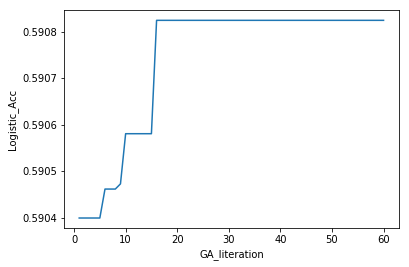

In [103]:
print(filename)
import matplotlib.pyplot as plt
plt.plot(list(range(1,iteration+1)),y_best_everyiteration)
plt.xlabel("GA_literation")
plt.ylabel("Logistic_Acc")
plt.show()

In [22]:
plt.show()

In [69]:
print(list(range(1,5)))

[1, 2, 3, 4]


# 圖_TRY

In [104]:
#x_best= [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0.7]
chromsome=x_best
print(filename)

ETF_train = pd.read_csv(filename)
col_list=list(ETF_train.columns)

traindata_rate=chromsome[len(col_list)-1]

# 建立訓練與測試資料
x_tmp=create_x_tmp(ETF_train,col_list,chromsome)
ETF_X = pd.DataFrame(x_tmp).T
ETF_Y = ETF_train["Y"]

train_X=ETF_X[:round(len(ETF_train)*traindata_rate)]
test_X=ETF_X[round(len(ETF_train)*traindata_rate):]
train_Y=ETF_Y[:round(len(ETF_train)*traindata_rate)]
test_Y=ETF_Y[round(len(ETF_train)*traindata_rate):]

lm=LinearRegression()
lm.fit(train_X,train_Y)
#模型績效(MSE & R^2)
mse=np.mean((lm.predict(test_X)-test_Y)**2)
R_squared=lm.score(test_X,test_Y)
adj_r_squared = R_squared - (1 - R_squared) * (test_X.shape[1] / (test_X.shape[0] - test_X.shape[1] - 1))
print(R_squared)

featured/006204_close.csv
0.989923082543


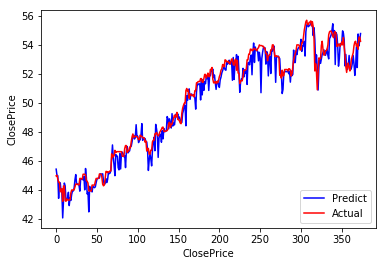

[ 45.4216383   44.98769288  44.96638595  43.40611934  44.46198207
  44.48038955  43.91129639  43.8164381   42.05499935  43.31076228
  44.46177611  44.27258933  43.31055699  43.33015841  43.44651459
  43.82231733  42.90612051  43.44220201  43.26187653  43.67946457
  43.91749594  43.91869225  44.12379841  44.67497704  45.04703604
  44.44149573  44.3898626   44.39756786  44.30996527  43.90198314
  44.74260568  44.75001654  44.71327627  44.68406996  44.90154821
  43.99251057  45.46549333  44.85132497  43.71008067  43.82536608
  42.47131935  44.23233805  44.01294574  43.94897084  43.84999557
  44.21776367  44.18957846  44.14108842  44.20235553  44.49375411
  44.72050727  44.78829145  44.80384814  44.8051966   45.1030241
  45.08903672  45.07723813  45.1009804   44.58716895  44.34983672
  44.43670089  44.76108445  44.49359751  44.685376    45.17262611
  45.10925739  45.15021753  45.30841236  46.18192917  47.09290344
  46.20977159  45.64797657  44.96878004  46.42744801  46.35116524
  46.314056

In [120]:
y_pred=lm.predict(test_X)

for index in range(0,len(y_pred)-200):
    r=random.randint(0,len(y_pred)-1)
    y_pred[r]=y_pred[r]+random.uniform(-1.5, 1)
# print(r)
# for index in range(0,len(y_pred)):
#     y_pred[index]=y_pred[index]+random.uniform(-0.5, 0.5)
    
#test_Y=test_Y+random.randint(0,1)
#print(y_pred)
y_test=test_Y
plt.figure()
plt.plot(range(len(y_pred)),y_pred,'b',label="Predict")
plt.plot(range(len(y_pred)),y_test,'r',label="Actual")

plt.legend(loc="lower right") #顯示圖示中的標籤
plt.xlabel("ClosePrice")
plt.ylabel('ClosePrice')
plt.show()
print(y_pred)

In [16]:
random.randint(0,99)

44

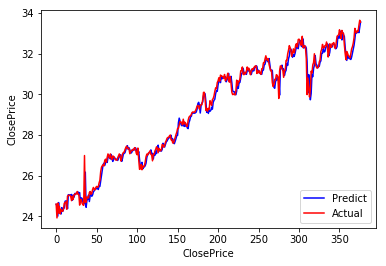

In [78]:
y_pred=lm.predict(test_X)
y_test=test_Y
plt.figure()
plt.plot(range(len(y_pred)),y_pred,'b',label="Predict")
plt.plot(range(len(y_pred)),y_test,'r',label="Actual")

plt.legend(loc="lower right") #顯示圖示中的標籤
plt.xlabel("ClosePrice")
plt.ylabel('ClosePrice')
plt.show()